# Direct Marketing
## Predicting pontential customers

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 45211 records and 17 fields.

In [2]:
data = pd.read_csv('bank-full.csv', header=0, sep=';')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(45211, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day: last contact day duration

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - balance: bank balance of the customer




#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [5]:
data['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [6]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns

In [7]:
data['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

### Data exploration

In [8]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

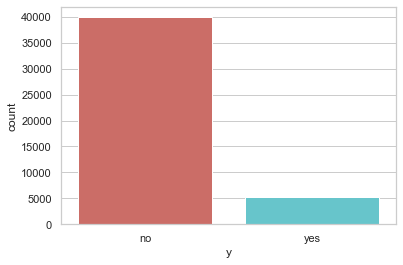

<Figure size 432x288 with 0 Axes>

In [9]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

Let's get a sense of the numbers across the two classes

In [10]:
data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't.
The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [11]:
data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630
blue-collar,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138
entrepreneur,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144
housemaid,46.415323,1392.395161,16.002419,245.825000,2.820968,21.505645,0.371774
management,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006
retired,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693
self-employed,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615
services,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204
student,26.542644,1388.060768,14.897655,246.656716,2.299574,57.041578,0.953092


In [12]:
data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.782984,1178.872287,15.796428,262.517188,2.630882,41.001728,0.551373
married,43.408099,1425.925590,15.854487,253.412765,2.842875,37.950467,0.556552
single,33.703440,1301.497654,15.708210,266.497967,2.649805,44.652385,0.642690


In [13]:
data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,45.865567,1250.949934,15.421398,255.933002,2.834331,36.081740,0.489272
secondary,39.964270,1154.880786,15.759159,258.685760,2.700802,42.353504,0.567753
tertiary,39.593640,1758.416435,16.086535,258.518532,2.825577,39.024134,0.661980
unknown,44.510501,1526.754443,15.810985,257.313947,2.849219,36.856220,0.488422


Visualizations

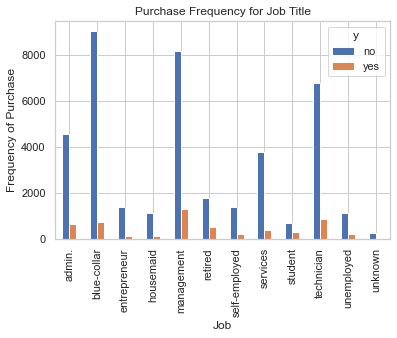

In [14]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

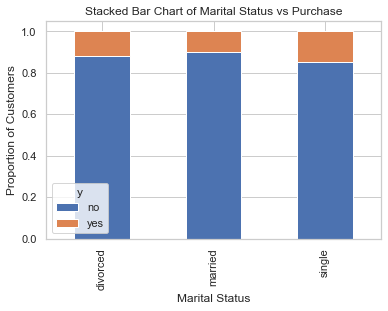

In [15]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

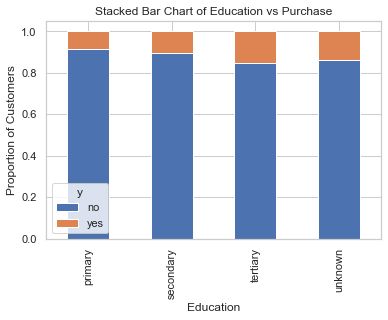

In [16]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

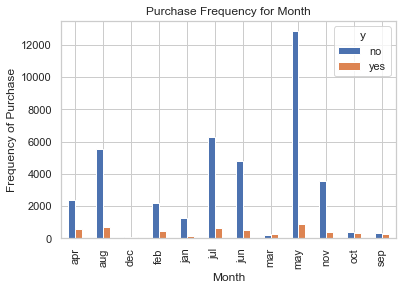

In [17]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable

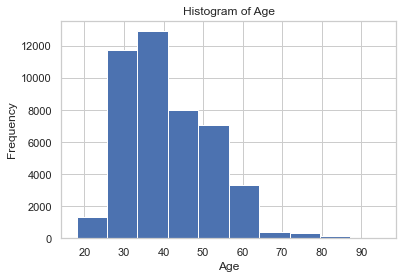

In [18]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

The most of the customers of the bank in this dataset are in the age range of 30-40.

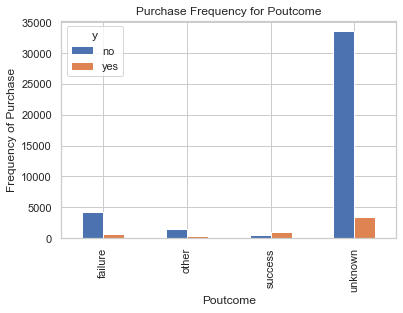

In [19]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [20]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list, how='left', rsuffix="_r" )
    data = data1

In [21]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [22]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [23]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
print(X)
print(len(X))

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']
51


### Feature Selection

In [24]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(data_final[X], data_final[y] )
print(rfe.support_)
print(rfe.ranking_)
temp_ranking_list = rfe.ranking_


C:\Users\baps\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\baps\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\baps\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

In [25]:
# Adding rank and attributes in to key value pair and sorting them to get top ranking attributes basend on RFE ranking
rank_att_dict = {}
for i in range (len(X)):
    rank_att_dict[X[i]] = temp_ranking_list[i]
{k: v for k, v in sorted(rank_att_dict.items(), key=lambda item: item[1])}

{'job_retired': 1,
 'job_student': 1,
 'housing_yes': 1,
 'loan_no': 1,
 'contact_cellular': 1,
 'contact_unknown': 1,
 'month_aug': 1,
 'month_dec': 1,
 'month_feb': 1,
 'month_jan': 1,
 'month_jul': 1,
 'month_mar': 1,
 'month_may': 1,
 'month_nov': 1,
 'month_oct': 1,
 'month_sep': 1,
 'poutcome_failure': 1,
 'poutcome_other': 1,
 'poutcome_success': 1,
 'poutcome_unknown': 1,
 'marital_married': 2,
 'housing_no': 3,
 'education_primary': 4,
 'contact_telephone': 5,
 'job_housemaid': 6,
 'loan_yes': 7,
 'job_unemployed': 8,
 'education_tertiary': 9,
 'default_yes': 10,
 'month_jun': 11,
 'month_apr': 12,
 'job_entrepreneur': 13,
 'job_unknown': 14,
 'campaign': 15,
 'marital_divorced': 16,
 'job_blue-collar': 17,
 'education_secondary': 18,
 'job_services': 19,
 'job_self-employed': 20,
 'job_technician': 21,
 'job_management': 22,
 'education_unknown': 23,
 'default_no': 24,
 'job_admin.': 25,
 'previous': 26,
 'marital_single': 27,
 'duration': 28,
 'day': 29,
 'age': 30,
 'pdays'

The Recursive Feature Elimination (RFE) has helped us select the following features: 'job_retired','job_student','housing_yes','loan_no','contact_cellular','contact_unknown','month_aug','month_dec','month_feb','month_jan','month_jul','month_mar','month_may','month_nov','month_oct','month_sep','poutcome_failure','poutcome_other','poutcome_success','poutcome_unknown'

In [28]:
cols=['job_retired','job_student','housing_yes','loan_no','contact_cellular','contact_unknown','month_aug','month_dec','month_feb','month_jan','month_jul','month_mar','month_may','month_nov','month_oct','month_sep','poutcome_failure','poutcome_other','poutcome_success','poutcome_unknown'] 
X=data_final[cols]
y=data_final['y']

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

### Implementing the model

In [29]:
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(float), X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.303576
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45211
Model:                          Logit   Df Residuals:                    45191
Method:                           MLE   Df Model:                           19
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.1588
Time:                        17:12:54   Log-Likelihood:                -13725.
converged:                       True   LL-Null:                       -16315.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
job_retired          0.3993      0.061      6.508      0.000       0.279       0.520
job_student

The p-values for most of the variables are very small, therefore, most of them are significant to the model. 

### Logistic Regression Model Fitting

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

#### Predicting the test set results and caculating the accuracy

In [31]:
y_pred = logreg.predict(X_test)

In [32]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


### Cross Validation

In [33]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

C:\Users\baps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
10-fold cross validation average accuracy: 0.893


### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11762   207]
 [ 1284   311]]


The result is telling us that we have 11762+311 correct predictions and 1284+207 incorrect predictions.

#### Accuracy

#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11969
           1       0.60      0.19      0.29      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.59      0.62     13564
weighted avg       0.87      0.89      0.86     13564



#### Interpretation: 

Of the entire test set, 88% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 90% of the customer's preferred term deposit were promoted.

### ROC Curvefrom sklearn import metrics
from ggplot import *

prob = clf1.predict_proba(X_test)[:,1]
fpr, sensitivity, _ = metrics.roc_curve(Y_test, prob)

df = pd.DataFrame(dict(fpr=fpr, sensitivity=sensitivity))
ggplot(df, aes(x='fpr', y='sensitivity')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

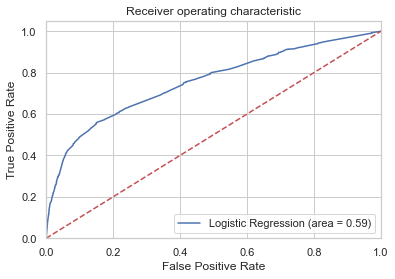

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()